# **Analiza koszykowa**

Importowanie bibliotek

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import warnings
warnings.filterwarnings('ignore')
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

Importowanie tabel

In [ ]:
transactions = pd.read_csv('transactions.csv')
transaction_items_prior = pd.read_csv('transaction_items__prior.csv')
transaction_items_train = pd.read_csv('transaction_items__train.csv')
items = pd.read_csv('items.csv')
categories = pd.read_csv('categories.csv')

# **Modyfikacja danych**

In [ ]:
transactions.head()

,Unnamed: 0,transaction_id,customer_id,eval_set,transaction_number,day_of_week,time_of_day,days_since_prior_order
0,0,2539329.0,1.0,prior,1.0,2.0,8.0,NaN
1,1,2398795.0,1.0,prior,2.0,3.0,7.0,15.0
2,2,473747.0,1.0,prior,3.0,3.0,12.0,21.0
3,3,2254736.0,1.0,prior,4.0,4.0,7.0,29.0
4,4,431534.0,1.0,prior,5.0,4.0,15.0,28.0


In [ ]:
transactions.dtypes

Unnamed: 0                 int64
transaction_id            object
customer_id               object
eval_set                  object
transaction_number        object
day_of_week               object
time_of_day               object
days_since_prior_order    object
dtype: object

In [ ]:
transactions.days_since_prior_order.unique()

array([nan, '15.0', '21.0', '29.0', '28.0', '19.0', '20.0', '14.0', '0.0',
       '30.0', '10.0', '3.0', '8.0', '13.0', '27.0', '6.0', '9.0', '12.0',
       '7.0', '17.0', '11.0', '4.0', '5.0', '2.0', 'unknown', '23.0',
       '26.0', '16.0', '1.0', '18.0', '24.0', '22.0', '25.0'],
      dtype=object)

In [ ]:
transactions.loc[transactions.days_since_prior_order.isna(), 'days_since_prior_order'] = 0
transactions = transactions[transactions.days_since_prior_order != 'unknown']

In [ ]:
transactions = transactions.drop(columns=['Unnamed: 0'])

In [ ]:
transactions = transactions[(transactions.transaction_id.isna() == False) & (transactions.transaction_id != 'unknown')]
transactions = transactions[(transactions.customer_id.isna() == False) & (transactions.customer_id != 'unknown')]

In [ ]:
transaction_items_prior.head()

,Unnamed: 0,transaction_id,item_id,add_to_cart_order,previous_bought
0,0,2.0,33120.0,1.0,1.0
1,1,2.0,28985.0,2.0,1.0
2,2,NaN,9327.0,3.0,0.0
3,3,2.0,45918.0,4.0,1.0
4,4,2.0,30035.0,5.0,0.0


In [ ]:
transaction_items_prior = transaction_items_prior[(transaction_items_prior.transaction_id.isna() == False) &
                                                  (transaction_items_prior.transaction_id != 'unknown')]

transaction_items_prior = transaction_items_prior[(transaction_items_prior.item_id.isna() == False) &
                                                  (transaction_items_prior.item_id != 'unknown')]

In [ ]:
transaction_items_prior = transaction_items_prior.drop(columns=['Unnamed: 0'])

In [ ]:
transaction_items_train.head()

,Unnamed: 0,transaction_id,item_id,add_to_cart_order,previous_bought
0,0,1.0,49302.0,1.0,1.0
1,1,1.0,11109.0,2.0,1.0
2,2,1.0,10246.0,3.0,0.0
3,3,1.0,49683.0,4.0,0.0
4,4,1.0,43633.0,5.0,1.0


In [ ]:
transaction_items_train = transaction_items_train[(transaction_items_train.transaction_id.isna() == False) &
                                                  (transaction_items_train.transaction_id != 'unknown')]

transaction_items_train = transaction_items_train[(transaction_items_train.item_id.isna() == False) &
                                                  (transaction_items_train.item_id != 'unknown')]

In [ ]:
transaction_items_train = transaction_items_train.drop(columns=['Unnamed: 0'])

In [ ]:

transactions_items = pd.concat([transaction_items_train[['transaction_id', 'item_id']],
                       transaction_items_prior[['transaction_id', 'item_id']]], ignore_index=True)
transactions_items

,transaction_id,item_id
0,1.0,49302.0
1,1.0,11109.0
2,1.0,10246.0
3,1.0,49683.0
4,1.0,43633.0
...,...,...
3864289,293782.0,31242.0
3864290,293782.0,29610.0
3864291,293782.0,14809.0
3864292,293782.0,2855.0


In [ ]:
print('Number of missing values in transaction_id: ', sum(transactions_items.transaction_id.isna()))
print('Number of missing values in item_id: ', sum(transactions_items.item_id.isna()))

Number of missing values in transaction_id:  0
Number of missing values in item_id:  0


In [ ]:
items.head()

,Unnamed: 0,item_id,item_name,alley_id,category
0,0,1.0,Chocolate Sandwich Cookies,61.0,19.0
1,1,2.0,All-Seasons Salt,104.0,13.0
2,2,3.0,Robust Golden Unsweetened Oolong Tea,94.0,7.0
3,3,4.0,Smart Ones Classic Favorites Mini Rigatoni Wit...,38.0,1.0
4,4,5.0,Green Chile Anytime Sauce,5.0,13.0


In [ ]:
items.category.unique()

array(['19.0', '13.0', '7.0', '1.0', '11.0', '16.0', '17.0', '18.0',
       '12.0', '9.0', '8.0', 'unknown', nan, '14.0', '15.0', '21.0',
       '4.0', '6.0', '20.0', '5.0', '3.0', '2.0', '10.0'], dtype=object)

In [ ]:
items = items.loc[(items.category.isna() == False) & (items.category != 'unknown')]
items = items.loc[(items.item_id.isna()==False) & (items.item_id != 'unknown')]

In [ ]:
categories.head()

,Unnamed: 0,category_id,category
0,0,1,frozen
1,1,2,other
2,2,3,bakery
3,3,4,produce
4,4,5,alcohol


In [ ]:
categories = categories.drop(columns = 'Unnamed: 0')

In [ ]:
categories.dtypes

category_id     int64
category       object
dtype: object

In [ ]:
categories.category_id = categories.category_id.astype(float)
categories.dtypes

category_id    float64
category        object
dtype: object

Przygotowanie danych do tworzenia analizy koszykowej

In [ ]:
transactions1 = transactions.loc[(transactions.eval_set == 'prior') | (transactions.eval_set == 'train')]

transaction1= transactions1.loc[(transactions1['transaction_id'].isna() == False) & (transactions1['transaction_id'] != 'unknown'),
                               ['transaction_id','day_of_week']]

transaction1= transactions1.loc[(transactions1['day_of_week'].isna() == False) & (transactions1['day_of_week'] != 'unknown'),
                               ['transaction_id','day_of_week']]

transaction1

,transaction_id,day_of_week
0,2539329.0,2.0
1,2398795.0,3.0
2,473747.0,3.0
3,2254736.0,4.0
4,431534.0,4.0
...,...,...
1869075,457318.0,6.0
1869076,2815061.0,1.0
1869077,2201275.0,0.0
1869079,2477581.0,0.0


In [ ]:
transactions_items = pd.concat([transaction_items_train[['transaction_id', 'item_id']],
                                transaction_items_prior[['transaction_id', 'item_id']]], ignore_index=True)
transactions_items.head()

,transaction_id,item_id
0,1.0,49302.0
1,1.0,11109.0
2,1.0,10246.0
3,1.0,49683.0
4,1.0,43633.0


In [ ]:
tran_day_item = transaction1.merge(transactions_items,how='left', on='transaction_id')
tran_day_item.head()

,transaction_id,day_of_week,item_id
0,2539329.0,2.0,NaN
1,2398795.0,3.0,NaN
2,473747.0,3.0,NaN
3,2254736.0,4.0,NaN
4,431534.0,4.0,NaN


In [ ]:
to_associate = tran_day_item.merge(items[['item_id','category']], how='left', on='item_id')
to_associate.head()

,transaction_id,day_of_week,item_id,category
0,2539329.0,2.0,NaN,NaN
1,2398795.0,3.0,NaN,NaN
2,473747.0,3.0,NaN,NaN
3,2254736.0,4.0,NaN,NaN
4,431534.0,4.0,NaN,NaN


In [ ]:
to_associate.rename(columns = {'category':'category_id'}, inplace = True)
to_associate.head()

,transaction_id,day_of_week,item_id,category_id
0,2539329.0,2.0,NaN,NaN
1,2398795.0,3.0,NaN,NaN
2,473747.0,3.0,NaN,NaN
3,2254736.0,4.0,NaN,NaN
4,431534.0,4.0,NaN,NaN


In [ ]:
to_associate.dtypes

transaction_id    object
day_of_week       object
item_id           object
category_id       object
dtype: object

In [ ]:
to_associate.category_id = to_associate.category_id.astype(float)

In [ ]:
to_associate = to_associate.merge(categories[['category_id','category']], how='left', on='category_id')

In [ ]:
to_associate.day_of_week.unique()

array(['2.0', '3.0', '4.0', '1.0', '5.0', '0.0', '6.0'], dtype=object)

In [ ]:
to_associate.day_of_week = to_associate.day_of_week.astype(float)
to_associate.day_of_week = to_associate.day_of_week.astype(int)
to_associate['day_of_week'] = to_associate['day_of_week'].replace([0,1,2,3,4,5,6],
                                            ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
to_associate.head()

,transaction_id,day_of_week,item_id,category_id,category
0,2539329.0,Wednesday,NaN,NaN,NaN
1,2398795.0,Thursday,NaN,NaN,NaN
2,473747.0,Thursday,NaN,NaN,NaN
3,2254736.0,Friday,NaN,NaN,NaN
4,431534.0,Friday,NaN,NaN,NaN


In [ ]:
to_associate_items = to_associate.loc[:,['transaction_id', 'item_id']]
to_associate_items.head()

,transaction_id,item_id
0,2539329.0,NaN
1,2398795.0,NaN
2,473747.0,NaN
3,2254736.0,NaN
4,431534.0,NaN


In [ ]:
to_associate_items['qty'] = 1

In [ ]:
products = pd.DataFrame(to_associate_items.groupby(['item_id'])['qty'].sum().sort_values(ascending=False))
products.head()

,qty
item_id,
24852.0,26725
13176.0,21380
21137.0,15022
21903.0,13743
47209.0,11390


In [ ]:
products['freq'] = products['qty']/len(to_associate_items)
products.tail()
products.describe()

,qty,freq
count,40387.000000,4.038700e+04
mean,46.200659,1.405947e-05
std,301.095059,9.162718e-05
min,1.000000,3.043131e-07
25%,2.000000,6.086262e-07
50%,6.000000,1.825879e-06
75%,22.000000,6.694889e-06
max,26725.000000,8.132768e-03


In [ ]:
products_top = products[products['freq']>0.001]
products_top

,qty,freq
item_id,,
24852.0,26725,0.008133
13176.0,21380,0.006506
21137.0,15022,0.004571
21903.0,13743,0.004182
47209.0,11390,0.003466
47766.0,9982,0.003038
47626.0,9398,0.002860
16797.0,8403,0.002557
26209.0,8108,0.002467


In [ ]:
to_associate_items_reduced = to_associate_items.loc[to_associate_items.item_id.isin(products_top.index), ['transaction_id', 'item_id']]

In [ ]:
to_associate_items_reduced.head()

,transaction_id,item_id
17,1187899.0,27845.0
18,1187899.0,49235.0
39,1492625.0,24852.0
40,1492625.0,45066.0
82,157374.0,40706.0


In [ ]:
basket = pd.get_dummies(to_associate_items_reduced, columns = ['item_id'], drop_first = False)

In [ ]:
basket.head()

,transaction_id,item_id_10749.0,item_id_13176.0,item_id_16797.0,item_id_17794.0,item_id_19057.0,item_id_21137.0,item_id_21616.0,item_id_21903.0,item_id_22935.0,...,item_id_47626.0,item_id_47766.0,item_id_4920.0,item_id_49235.0,item_id_49683.0,item_id_5077.0,item_id_5876.0,item_id_8277.0,item_id_8518.0,item_id_9076.0
17,1187899.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,1187899.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
39,1492625.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,1492625.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82,157374.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
basket = basket.set_index('transaction_id')

In [ ]:
basket.head()

,item_id_10749.0,item_id_13176.0,item_id_16797.0,item_id_17794.0,item_id_19057.0,item_id_21137.0,item_id_21616.0,item_id_21903.0,item_id_22935.0,item_id_24184.0,...,item_id_47626.0,item_id_47766.0,item_id_4920.0,item_id_49235.0,item_id_49683.0,item_id_5077.0,item_id_5876.0,item_id_8277.0,item_id_8518.0,item_id_9076.0
transaction_id,,,,,,,,,,,,,,,,,,,,,
1187899.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1187899.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1492625.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1492625.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157374.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
frequent_itemsets = apriori(basket, min_support=0.007, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0)
rules.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


## Categories


In [ ]:
to_associate_cat = to_associate.loc[:,['transaction_id', 'category']]
to_associate_cat.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,transaction_id,category
0,2539329.0,NaN
1,2398795.0,NaN
2,473747.0,NaN
3,2254736.0,NaN
4,431534.0,NaN


In [ ]:
to_associate_cat['qty'] = 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
to_associate_cat.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,transaction_id,category,qty
0,2539329.0,NaN,1
1,2398795.0,NaN,1
2,473747.0,NaN,1
3,2254736.0,NaN,1
4,431534.0,NaN,1


In [ ]:
products = pd.DataFrame(to_associate_cat.groupby(['category'])['qty'].sum().sort_values(ascending=False))
products.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,qty
category,
produce,519791
dairy eggs,283422
snacks,153701
beverages,142778
frozen,124074


In [ ]:
products['freq'] = products['qty']/len(to_associate_cat)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
products.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,qty,freq
count,21.000000,21.000000
mean,83187.666667,0.025315
std,121040.974282,0.036834
min,1805.000000,0.000549
25%,14568.000000,0.004433
50%,41697.000000,0.012689
75%,98654.000000,0.030022
max,519791.000000,0.158179


In [ ]:
products_top = products[products['freq']>0.02]
products_top

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,qty,freq
category,,
produce,519791,0.158179
dairy eggs,283422,0.086249
snacks,153701,0.046773
beverages,142778,0.043449
frozen,124074,0.037757
pantry,98654,0.030022


In [ ]:
to_associate_cat_reduced = to_associate_cat.loc[to_associate_cat.category.isin(products_top.index),
                                                ['transaction_id', 'category']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
to_associate_cat_reduced

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,transaction_id,category
9,1187899.0,beverages
10,1187899.0,dairy eggs
11,1187899.0,dairy eggs
13,1187899.0,snacks
14,1187899.0,snacks
...,...,...
3286075,172613.0,snacks
3286076,172613.0,snacks
3286078,1061430.0,dairy eggs
3286081,1061430.0,produce


In [ ]:
from efficient_apriori import apriori

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pip install efficient-apriori

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
category_list = to_associate_cat_reduced.groupby("transaction_id")['category']
category_list = pd.DataFrame(category_list.apply(','.join).str.split(',', expand = True))
category_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
transaction_id,,,,,,,,,,,,,,,,,,,,,
1.0,dairy eggs,produce,produce,produce,produce,dairy eggs,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1000.0,produce,snacks,dairy eggs,pantry,snacks,produce,beverages,None,None,None,...,None,None,None,None,None,None,None,None,None,None
10000.0,snacks,snacks,dairy eggs,dairy eggs,produce,produce,pantry,snacks,produce,None,...,None,None,None,None,None,None,None,None,None,None
1000029.0,produce,produce,produce,produce,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
100005.0,produce,produce,produce,dairy eggs,produce,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999926.0,dairy eggs,frozen,frozen,frozen,dairy eggs,frozen,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
99994.0,dairy eggs,dairy eggs,produce,produce,produce,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
999964.0,dairy eggs,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
basket = [tuple([y for y in x if y is not None]) for x in  category_list.values]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
basket

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('dairy eggs', 'produce', 'produce', 'produce', 'produce', 'dairy eggs'),
 ('produce',
  'snacks',
  'dairy eggs',
  'pantry',
  'snacks',
  'produce',
  'beverages'),
 ('snacks',
  'snacks',
  'dairy eggs',
  'dairy eggs',
  'produce',
  'produce',
  'pantry',
  'snacks',
  'produce'),
 ('produce', 'produce', 'produce', 'produce'),
 ('produce', 'produce', 'produce', 'dairy eggs', 'produce'),
 ('produce', 'dairy eggs', 'produce', 'dairy eggs', 'produce', 'frozen'),
 ('beverages',
  'beverages',
  'beverages',
  'beverages',
  'snacks',
  'beverages',
  'snacks',
  'produce',
  'frozen',
  'produce',
  'frozen',
  'frozen',
  'frozen',
  'frozen'),
 ('dairy eggs', 'pantry', 'dairy eggs', 'dairy eggs'),
 ('produce',),
 ('snacks', 'beverages', 'beverages'),
 ('frozen',
  'produce',
  'frozen',
  'produce',
  'frozen',
  'dairy eggs',
  'beverages',
  'snacks'),
 ('frozen',
  'frozen',
  'dairy eggs',
  'dairy eggs',
  'dairy eggs',
  'produce',
  'produce',
  'produce',
  'produce',
  'p

In [ ]:
category_sets, rules = apriori(basket, min_support=0.1,min_confidence=0.8)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(rules)

[{pantry} -> {produce}, {beverages, dairy eggs} -> {produce}, {beverages, frozen} -> {produce}, {beverages, pantry} -> {produce}, {frozen, pantry} -> {dairy eggs}, {dairy eggs, frozen} -> {produce}, {dairy eggs, pantry} -> {produce}, {dairy eggs, snacks} -> {produce}, {frozen, pantry} -> {produce}, {frozen, snacks} -> {produce}, {pantry, snacks} -> {produce}, {beverages, frozen, produce} -> {dairy eggs}, {beverages, dairy eggs, frozen} -> {produce}, {beverages, pantry, produce} -> {dairy eggs}, {beverages, dairy eggs, pantry} -> {produce}, {beverages, produce, snacks} -> {dairy eggs}, {beverages, dairy eggs, snacks} -> {produce}, {frozen, pantry, produce} -> {dairy eggs}, {dairy eggs, frozen, pantry} -> {produce}, {frozen, produce, snacks} -> {dairy eggs}, {dairy eggs, frozen, snacks} -> {produce}, {pantry, produce, snacks} -> {dairy eggs}, {dairy eggs, pantry, snacks} -> {produce}]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rules_rhs = filter(lambda rule: len(rule.lhs) == 2 and len(rule.rhs) == 1, rules)
rule_l = []
rule_r = []
rule_support = []
rule_conf = []
rule_lift = []
for rule in sorted(rules_rhs, key=lambda rule: rule.lift):
    rule_l.append(rule.lhs)
    rule_r.append(rule.rhs)
    rule_support.append(rule.support)
    rule_conf.append(rule.confidence)
    rule_lift.append(rule.lift)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
association = pd.DataFrame({'antecedents': rule_l ,
             'consequents': rule_r,
             'support': rule_support,
             'confidence': rule_conf,
             'lift': rule_lift})
association

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,support,confidence,lift
0,"(beverages, frozen)","(produce,)",0.137030,0.800549,1.064725
1,"(beverages, dairy eggs)","(produce,)",0.235921,0.802685,1.067566
2,"(frozen, snacks)","(produce,)",0.149104,0.821973,1.093219
3,"(beverages, pantry)","(produce,)",0.122661,0.822242,1.093577
4,"(dairy eggs, snacks)","(produce,)",0.246334,0.826806,1.099647
5,"(pantry, snacks)","(produce,)",0.132119,0.836177,1.112110
6,"(dairy eggs, frozen)","(produce,)",0.225745,0.844016,1.122536
7,"(dairy eggs, pantry)","(produce,)",0.206734,0.851886,1.133003
8,"(frozen, pantry)","(produce,)",0.122159,0.853877,1.135651
9,"(frozen, pantry)","(dairy eggs,)",0.115866,0.809889,1.227846


In [ ]:
association["rule"] = association["antecedents"].apply(lambda x: ', '.join(list(x))).astype("unicode") + \
        ' -> ' + association["consequents"].apply(lambda x: ', '.join(list(x))).astype("unicode")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
association

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,support,confidence,lift,rule
0,"(beverages, frozen)","(produce,)",0.137030,0.800549,1.064725,"beverages, frozen -> produce"
1,"(beverages, dairy eggs)","(produce,)",0.235921,0.802685,1.067566,"beverages, dairy eggs -> produce"
2,"(frozen, snacks)","(produce,)",0.149104,0.821973,1.093219,"frozen, snacks -> produce"
3,"(beverages, pantry)","(produce,)",0.122661,0.822242,1.093577,"beverages, pantry -> produce"
4,"(dairy eggs, snacks)","(produce,)",0.246334,0.826806,1.099647,"dairy eggs, snacks -> produce"
5,"(pantry, snacks)","(produce,)",0.132119,0.836177,1.112110,"pantry, snacks -> produce"
6,"(dairy eggs, frozen)","(produce,)",0.225745,0.844016,1.122536,"dairy eggs, frozen -> produce"
7,"(dairy eggs, pantry)","(produce,)",0.206734,0.851886,1.133003,"dairy eggs, pantry -> produce"
8,"(frozen, pantry)","(produce,)",0.122159,0.853877,1.135651,"frozen, pantry -> produce"
9,"(frozen, pantry)","(dairy eggs,)",0.115866,0.809889,1.227846,"frozen, pantry -> dairy eggs"


In [ ]:
association[['support', 'confidence', 'lift']] = association[['support', 'confidence', 'lift']].round(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
association.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,support,confidence,lift,rule
0,"(beverages, frozen)","(produce,)",0.14,0.80,1.06,"beverages, frozen -> produce"
1,"(beverages, dairy eggs)","(produce,)",0.24,0.80,1.07,"beverages, dairy eggs -> produce"
2,"(frozen, snacks)","(produce,)",0.15,0.82,1.09,"frozen, snacks -> produce"
3,"(beverages, pantry)","(produce,)",0.12,0.82,1.09,"beverages, pantry -> produce"
4,"(dairy eggs, snacks)","(produce,)",0.25,0.83,1.10,"dairy eggs, snacks -> produce"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


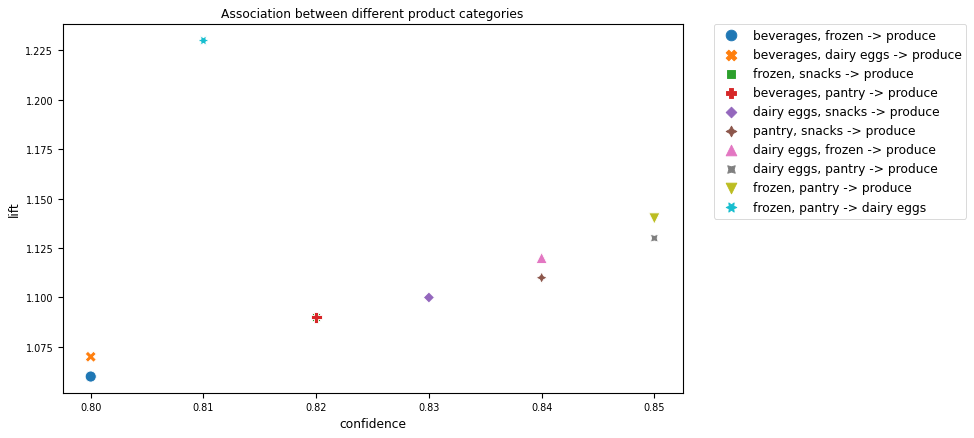

In [ ]:
fig = figure(figsize=(10, 6), dpi=80)
sns.set_context('paper')
sns.scatterplot(data=association,
                x = 'confidence',
                y = 'lift',
                hue = 'rule',
                style = 'rule',
                s = 100)

plt.title('Association between different product categories', fontsize = '11')
plt.legend(bbox_to_anchor=(1.05, 1),
           loc='upper left',
           borderaxespad=0,
           fontsize='11',
           markerscale=2)

plt.xlabel(xlabel = 'confidence', fontsize=11)
plt.ylabel(ylabel = 'lift', fontsize=11)

plt.savefig('ass_categories.jpg')
plt.show()